In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

# Global parameters for the figure.
plt.style.use('seaborn-deep')
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 28
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

### How the data was generated

1. The hidden variables for both networks were generated via
```
python generate_hidden_variables_for_reciprocity_validation.py
```
2. Directed networks according to the directed CM and $S^1$ models were generated and analyzed via 
```
python generate_synthetic_directedCM_networks_and_extract_network_properties_for_reciprocity_validation_all.py
python generate_synthetic_directedS1_networks_and_extract_network_properties_for_reciprocity_validation_all.py
```

### Gathers and analyzes the results of the numerical simulations for both models

In [2]:
def lower_bound(x):
    return np.percentile(x, 2.5)
    # return np.min(x)
def upper_bound(x):
    return np.percentile(x, 97.5)
    # return np.max(x)

df_num = pd.DataFrame()
for graph in ['graphA_00', 'graphB_00']:
    files = glob.glob('../../directedS1_data/synthetic_networks/network_properties/' + graph + '*_gprop.txt')
    for file in files:
        if "_beta" in file:
            beta = float(file.split('_beta')[1].split('_nu')[0].replace('p', '.'))
            model = 'S1'
        else:
            beta = "None"
            model = 'CM'
        nu = file.split('_nu')[1].split('_gprop')[0].replace('m', '-')
        if nu[0] == 'p':
            nu = nu[1:]
        nu = float(nu.replace('p', '.'))

        header = open(file, 'r').readline().replace('#', ' ').split()
        df_tmp = pd.read_table(file, names=header, comment="#", delimiter=r"\s+")
        df_tmp['nu'] = nu
        df_tmp['beta'] = beta
        df_tmp['graph'] = graph
        df_tmp['model'] = model
        df_num = df_num.append(df_tmp, ignore_index=True)

pt_num = pd.pivot_table(df_num, index=["graph", "model", "beta", "nu"], values=["reciprocity_ratio"], aggfunc=[np.mean, lower_bound, upper_bound])

### Computes the theoretical curves for the directed CM and the directed-reciprocal $S^1$ model

In [3]:
df_theo = pd.DataFrame() #columns=['graph', 'model', 'beta', 'L', 'num1', 'nu00', 'nup1'])
for graph in ['graphA_00', 'graphB_00']:
    file = '../../directedS1_data/synthetic_networks/hidden_variables/' + graph + '_hidden_variables.txt'
    header = open(file, 'r').readline().replace('#', ' ').split()
    df_tmp = pd.read_table(file, names=header, comment="#", delimiter=r"\s+")

    pij = 1 / (1 + np.sum(df_tmp['kappa_out']) / np.outer(df_tmp['kappa_out'], df_tmp['kappa_in']))
    np.fill_diagonal(pij, 0)
    pji = np.transpose(pij)

    L = np.sum(pij)
    nu00 = np.sum(np.multiply(pij, pji))
    nup1 = np.sum(np.minimum(pij, pji))
    num1 = np.sum((1 - pij - pji) * ((pij + pji - 1) > 0))

    df_theo = df_theo.append({'graph': graph, 'model': 'CM', 'L': L, 'num1': num1, 'nu00': nu00, 'nup1': nup1}, ignore_index=True)

    for beta in [1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 3.2]:
        mu = beta * np.sin(np.pi / beta) / (2 * np.pi * np.average(df_tmp['kappa_out']))
        pij = np.absolute(df_tmp['theta'].values.reshape(-1, 1) - df_tmp['theta'].values)
        pij = np.pi - np.absolute(np.pi - pij)
        # pij = np.minimum(pij, 2 * np.pi - pij)
        pij = 1 / (1 + (len(df_tmp['kappa_out']) * pij / (2 * np.pi * mu * np.outer(df_tmp['kappa_out'], df_tmp['kappa_in'])))**beta)
        np.fill_diagonal(pij, 0)
        pji = np.transpose(pij)
        
        L = np.sum(pij)
        nu00 = np.sum(np.multiply(pij, pji))
        nup1 = np.sum(np.minimum(pij, pji))
        num1 = np.sum((1 - pij - pji) * ((pij + pji - 1) > 0))

        df_theo = df_theo.append({'graph': graph, 'model': 'S1', 'beta': beta, 'L': L, 'num1': num1, 'nu00': nu00, 'nup1': nup1}, ignore_index=True)
df_theo.fillna(value="None", inplace=True)

### Generates the figures for the paper

In [5]:
def plot_theo(ax, graph, model, beta_value="None"):
    alpha = df_theo[(df_theo['graph'] == graph) & (df_theo['model'] == model) & (df_theo['beta'] == beta_value)]['nu00'].item()
    beta = df_theo[(df_theo['graph'] == graph) & (df_theo['model'] == model) & (df_theo['beta'] == beta_value)]['nup1'].item()
    gamma = df_theo[(df_theo['graph'] == graph) & (df_theo['model'] == model) & (df_theo['beta'] == beta_value)]['num1'].item()
    delta = df_theo[(df_theo['graph'] == graph) & (df_theo['model'] == model) & (df_theo['beta'] == beta_value)]['L'].item()

    ax.plot(np.append(np.arange(-1, 0, 0.01), np.arange(0, 1.01, 0.01)),
            np.append(((gamma + alpha) * np.arange(-1, 0, 0.01) + alpha) / delta,
                      ((beta - alpha) * np.arange(0, 1.01, 0.01) + alpha) / delta),
            linestyle="-", color="k", marker="None")

def plot_num(ax, graph, model, beta_value="None", marker="s"):
    if model == "S1":
        label = r"directed-reciprocal $\mathbb{{S}}^1$ model with $\beta = {}$".format(beta_value)
    else:
        label = r"directed-reciprocal soft $\mathrm{CM}$ $(\beta \to 0)$"
    val = pt_num.loc[graph, model, beta_value]["mean"]["reciprocity_ratio"]
    upper_bound = pt_num.loc[graph, model, beta_value]["upper_bound"]["reciprocity_ratio"] - val
    lower_bound = val - pt_num.loc[graph, model, beta_value]["lower_bound"]["reciprocity_ratio"]
    ax.errorbar(pt_num.loc[graph, model, beta_value]["mean"]["reciprocity_ratio"].index,
                val,
                yerr=[lower_bound, upper_bound],
                linestyle="None", marker=marker, markerfacecolor="None", label=label)

### (a) Fully correlated $\kappa^\mathrm{in}$ and $\kappa^\mathrm{out}$

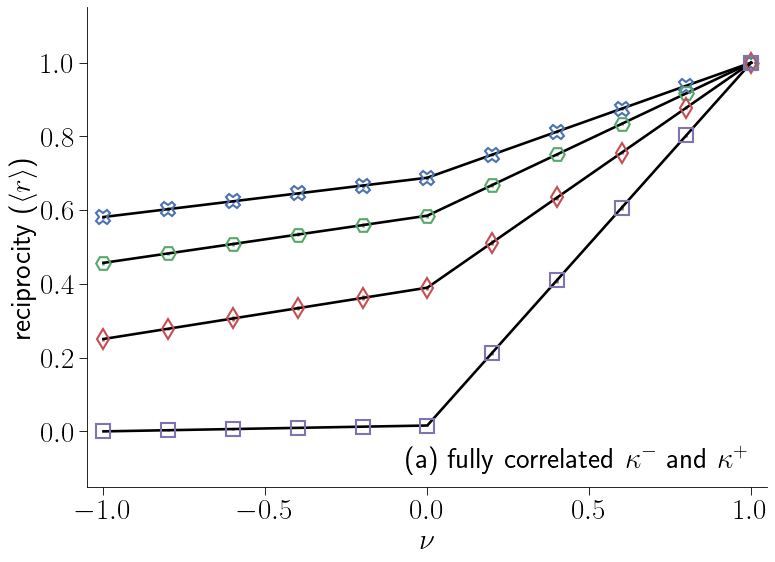

In [6]:
fig, ax = plt.subplots()

name = "graphA_00"

betas = [3.2, 2.4, 1.6]
markers = ['X', 'H', 'd']
for beta, marker in zip(betas, markers):
    plot_theo(ax, name, 'S1', beta)
    plot_num(ax, name, 'S1', beta, marker)
    
plot_theo(ax, name, 'CM')
plot_num(ax, name, 'CM')

plt.text(0.975, 0.025, r"(a) fully correlated $\kappa^-$ and $\kappa^+$",
         horizontalalignment='right',
         verticalalignment='bottom',
         fontsize='medium',
         transform=ax.transAxes)

ax.set(xlim=[-1.05,1.05], ylim=[-0.15,1.15])
ax.set_xlabel(r"$\nu$")
ax.set_ylabel(r"reciprocity ($\langle r \rangle$)")

# ax.set_xticklabels([])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ax.legend(loc="upper left", bbox_to_anchor=(-0.05, 1), bbox_transform=ax.transAxes, ncol=1)

fig.savefig("../figures/pdf/figure_paper_validation_reciprocity_graphA_00.pdf", bbox_inches='tight')
fig.savefig("../figures/svg/figure_paper_validation_reciprocity_graphA_00.svg", bbox_inches='tight')

### (b) Uncorrelated $\kappa^\mathrm{in}$ and $\kappa^\mathrm{out}$

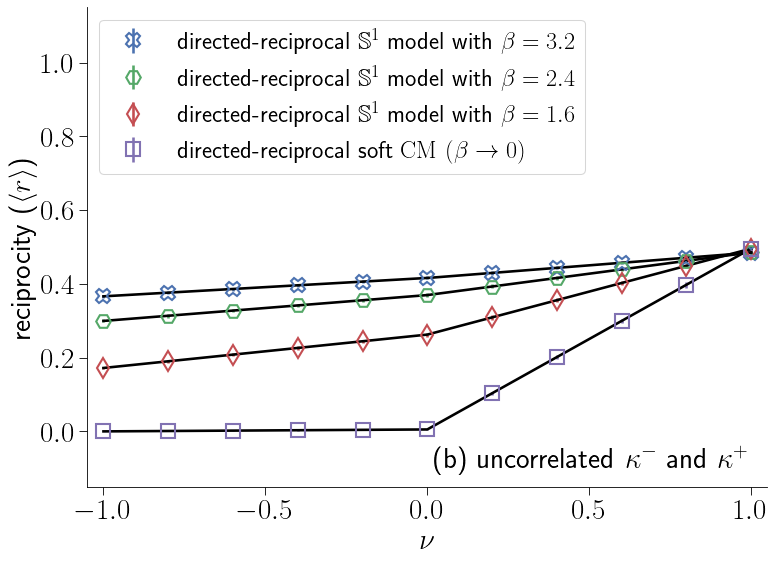

In [7]:
fig, ax = plt.subplots()

name = "graphB_00"

betas = [3.2, 2.4, 1.6]
markers = ['X', 'H', 'd']
for beta, marker in zip(betas, markers):
    plot_theo(ax, name, 'S1', beta)
    plot_num(ax, name, 'S1', beta, marker)
    
plot_theo(ax, name, 'CM')
plot_num(ax, name, 'CM')

plt.text(0.975, 0.025, r"(b) uncorrelated $\kappa^-$ and $\kappa^+$",
         horizontalalignment='right',
         verticalalignment='bottom',
         fontsize='medium',
         transform=ax.transAxes)

ax.set(xlim=[-1.05,1.05], ylim=[-0.15,1.15])
ax.set_xlabel(r"$\nu$")
ax.set_ylabel(r"reciprocity ($\langle r \rangle$)")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(loc="upper left", ncol=1)

fig.savefig("../figures/pdf/figure_paper_validation_reciprocity_graphB_00.pdf", bbox_inches='tight')
fig.savefig("../figures/svg/figure_paper_validation_reciprocity_graphB_00.svg", bbox_inches='tight')